### One or five Stars

Using Python and its Natural Language Processing capabilities, this project tries to classify Yelp-reviews based on the choice of words.

The data set used can be found on [kaggle.com](https://www.kaggle.com/c/yelp-recsys-2013) and includes over 10,000 businesses, 8,000 check-in sites, 40,000 users, and 200,000 reviews from the Phoenix, AZ metropolitan area. Due to computational limitations, only 10,000 of those will be used. 

Each observation in the data set is a review of a specific business by a specifiy user. The 'stars' column shows the number of stars from 1 to 5 (the higher the better) given by the reviewer to the business.

The 'cool' column shows the number of 'cool' votes the specific review received from other Yelp users, starting at 0 votes with no limit, and can be seen as a rating of the review itself. Same goes for the 'useful' and 'funny' columns.

In [39]:
# import data wrangling methods
import pandas as pd
import string

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import stopwords list
from nltk.corpus import stopwords

# import ML and NLP libraries / objects
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
# import data set
df = pd.read_csv('yelp.csv')
df.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0


In [22]:
# check data properties
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [24]:
# feature engineering: create column with text length of review
df['text length'] = df['text'].apply(len)

##### Exploratory data analysis.

Text(0, 0.5, '')

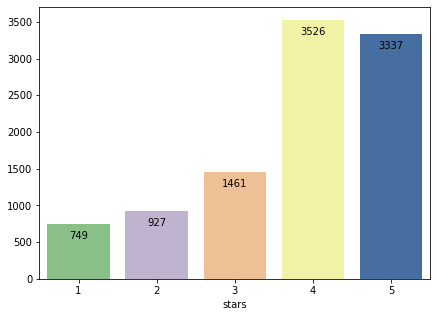

In [25]:
# visualize frequency of stars given by reviewers
plt.figure(figsize=(7, 5))
cplot = sns.countplot(x=df['stars'], palette='Accent')
for bar in cplot.patches:
    cplot.annotate(bar.get_height(), (bar.get_x() + bar.get_width() / 2., bar.get_height()-300), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('')

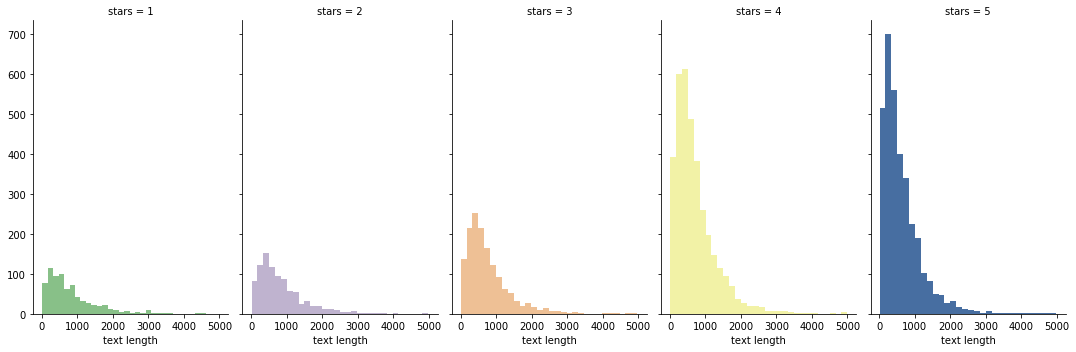

In [26]:
# compare stars based on count of different text length
g = sns.FacetGrid(df, col='stars', height=5, aspect=0.6,
                 hue_kws={'color': ['#88c088', '#bfb3cf', '#eec095', '#f2f2a6', '#476ea1']}, hue="stars")
g = g.map(plt.hist,'text length', bins=30)

plt.savefig('stars-text length.png', dpi=300)

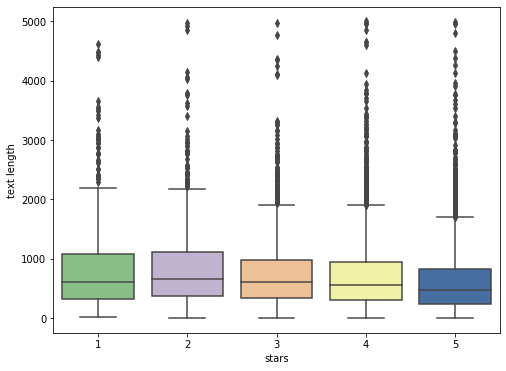

In [27]:
# compare stars based on distribution of review text length
plt.figure(figsize=(8, 6))
sns.boxplot(x='stars', y='text length', data=df, palette='Accent')
plt.savefig('stars-text length boxplot.png', dpi=300)

In [28]:
# getting mean of  'cool, 'useful' and 'funny' votes as well as text length per stars given
df.groupby(by='stars').mean()

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [29]:
# create correlation matrix
df_cor = df.groupby(by='stars').mean().corr()
df_cor

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


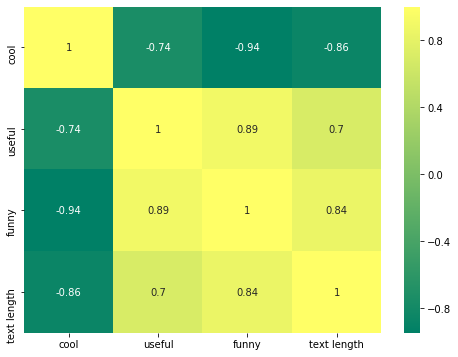

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_cor, annot=True, cmap='summer', )

# fix for mpl bug that cuts off top/bottom of seaborn heatmap
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.savefig('vote corr.png', dpi=300)
plt.show()

##### NLP Classification
Classification of the different reviews with 'Bag of Words' method using sklearns toolkit and Support Vector Classifier

In [56]:
# creating predictor (i.e. review text) and response (i.e. review rating) variables
yelp_class = df[(df.stars==1) | (df.stars==5)]

X = yelp_class['text']
y = yelp_class['stars']

yelp_class['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

In [32]:
# create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Reviews are classified using a pipeline with three steps:
1. Convert reviews into a sparse matrix with Count how many times does a word occur in each review
    - including text normalization
2. Weigh the counts using TF-IDF, a statistical measure used to evaluate how important a word is to a document (i.e. a single review) in a corpus of documents (i.e. all reviews)
2. Classify review (i.e. its weighted word count) using a grid search of Support Vector Mashine parameters (C, gamma, kernel, decision function shape)

In [40]:
# text normalization by defining function to exclude stopwords and punctuation

def review_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join characters
    nopunc = ''.join(nopunc)
    
    # Remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [41]:
# parameter grid for SVC
param_grid = {'C': [1, 10, 25, 50, 75, 100, 150], 'gamma': [1,0.1,0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear'], 'decision_function_shape':['ovo', 'ovr']} 

# greating grid object
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

In [42]:
# create pipeline with Count Vectorizer, TF-IDF Transformer and Support Vector Classifier
NLP_pl = Pipeline([
    ('bow', CountVectorizer(analyzer=review_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', grid)  # train on TF-IDF vectors w/ support vector classifier and grid search
])

In [43]:
# apply pipeline to reviews
NLP_pl.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 140 candidates, totalling 420 fits
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=rbf ...........
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=rbf, total=   2.1s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=rbf ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=rbf, total=   2.2s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=rbf ...........
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=rbf, total=   2.1s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear ........
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, total=   1.4s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear ........
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, total=   1.4s
[CV] C=1, decision_function_shape=ovo, gamma=1, kernel=linear ........
[CV]  C=1, decision_function_shape=ovo, gamma=1, kernel=linear, total=   1.4s
[CV] C=1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .........
[CV]  C=1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, total=   1.4s
[CV] C=1, decision_function_shape=ovo, gamma=0.1, kernel=rbf .........
[CV]  C=1, decision_function_shape=ovo, gamma=0.1, kernel=rbf, total=   1.4s
[CV] C=1, decision_function_shape=ov

[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, total=   1.4s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, total=   1.4s
[CV] C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear ...
[CV]  C=1, decision_function_shape=ovr, gamma=0.0001, kernel=linear, total=   1.4s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, total=   2.1s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, total=   2.1s
[CV] C=10, decision_function_shape=ovo, gamma=1, kernel=rbf ..........
[CV]  C=10, decision_function_shape=ovo, gamma=1, kernel=rbf, total=   2.2s
[CV] C=10, decisi

[CV]  C=10, decision_function_shape=ovr, gamma=0.001, kernel=linear, total=   1.8s
[CV] C=10, decision_function_shape=ovr, gamma=0.001, kernel=linear ...
[CV]  C=10, decision_function_shape=ovr, gamma=0.001, kernel=linear, total=   1.8s
[CV] C=10, decision_function_shape=ovr, gamma=0.001, kernel=linear ...
[CV]  C=10, decision_function_shape=ovr, gamma=0.001, kernel=linear, total=   1.8s
[CV] C=10, decision_function_shape=ovr, gamma=0.0001, kernel=rbf .....
[CV]  C=10, decision_function_shape=ovr, gamma=0.0001, kernel=rbf, total=   1.2s
[CV] C=10, decision_function_shape=ovr, gamma=0.0001, kernel=rbf .....
[CV]  C=10, decision_function_shape=ovr, gamma=0.0001, kernel=rbf, total=   1.2s
[CV] C=10, decision_function_shape=ovr, gamma=0.0001, kernel=rbf .....
[CV]  C=10, decision_function_shape=ovr, gamma=0.0001, kernel=rbf, total=   1.2s
[CV] C=10, decision_function_shape=ovr, gamma=0.0001, kernel=linear ..
[CV]  C=10, decision_function_shape=ovr, gamma=0.0001, kernel=linear, total=   1.7

[CV]  C=25, decision_function_shape=ovr, gamma=0.01, kernel=linear, total=   1.8s
[CV] C=25, decision_function_shape=ovr, gamma=0.01, kernel=linear ....
[CV]  C=25, decision_function_shape=ovr, gamma=0.01, kernel=linear, total=   1.8s
[CV] C=25, decision_function_shape=ovr, gamma=0.001, kernel=rbf ......
[CV]  C=25, decision_function_shape=ovr, gamma=0.001, kernel=rbf, total=   1.4s
[CV] C=25, decision_function_shape=ovr, gamma=0.001, kernel=rbf ......
[CV]  C=25, decision_function_shape=ovr, gamma=0.001, kernel=rbf, total=   1.4s
[CV] C=25, decision_function_shape=ovr, gamma=0.001, kernel=rbf ......
[CV]  C=25, decision_function_shape=ovr, gamma=0.001, kernel=rbf, total=   1.4s
[CV] C=25, decision_function_shape=ovr, gamma=0.001, kernel=linear ...
[CV]  C=25, decision_function_shape=ovr, gamma=0.001, kernel=linear, total=   1.8s
[CV] C=25, decision_function_shape=ovr, gamma=0.001, kernel=linear ...
[CV]  C=25, decision_function_shape=ovr, gamma=0.001, kernel=linear, total=   1.8s
[CV]

[CV]  C=50, decision_function_shape=ovr, gamma=0.1, kernel=linear, total=   1.8s
[CV] C=50, decision_function_shape=ovr, gamma=0.01, kernel=rbf .......
[CV]  C=50, decision_function_shape=ovr, gamma=0.01, kernel=rbf, total=   1.4s
[CV] C=50, decision_function_shape=ovr, gamma=0.01, kernel=rbf .......
[CV]  C=50, decision_function_shape=ovr, gamma=0.01, kernel=rbf, total=   1.4s
[CV] C=50, decision_function_shape=ovr, gamma=0.01, kernel=rbf .......
[CV]  C=50, decision_function_shape=ovr, gamma=0.01, kernel=rbf, total=   1.4s
[CV] C=50, decision_function_shape=ovr, gamma=0.01, kernel=linear ....
[CV]  C=50, decision_function_shape=ovr, gamma=0.01, kernel=linear, total=   1.8s
[CV] C=50, decision_function_shape=ovr, gamma=0.01, kernel=linear ....
[CV]  C=50, decision_function_shape=ovr, gamma=0.01, kernel=linear, total=   1.7s
[CV] C=50, decision_function_shape=ovr, gamma=0.01, kernel=linear ....
[CV]  C=50, decision_function_shape=ovr, gamma=0.01, kernel=linear, total=   1.8s
[CV] C=50,

[CV]  C=75, decision_function_shape=ovr, gamma=0.1, kernel=rbf, total=   1.8s
[CV] C=75, decision_function_shape=ovr, gamma=0.1, kernel=rbf ........
[CV]  C=75, decision_function_shape=ovr, gamma=0.1, kernel=rbf, total=   1.8s
[CV] C=75, decision_function_shape=ovr, gamma=0.1, kernel=rbf ........
[CV]  C=75, decision_function_shape=ovr, gamma=0.1, kernel=rbf, total=   1.8s
[CV] C=75, decision_function_shape=ovr, gamma=0.1, kernel=linear .....
[CV]  C=75, decision_function_shape=ovr, gamma=0.1, kernel=linear, total=   1.8s
[CV] C=75, decision_function_shape=ovr, gamma=0.1, kernel=linear .....
[CV]  C=75, decision_function_shape=ovr, gamma=0.1, kernel=linear, total=   1.7s
[CV] C=75, decision_function_shape=ovr, gamma=0.1, kernel=linear .....
[CV]  C=75, decision_function_shape=ovr, gamma=0.1, kernel=linear, total=   1.8s
[CV] C=75, decision_function_shape=ovr, gamma=0.01, kernel=rbf .......
[CV]  C=75, decision_function_shape=ovr, gamma=0.01, kernel=rbf, total=   1.8s
[CV] C=75, decisio

[CV]  C=100, decision_function_shape=ovr, gamma=1, kernel=rbf, total=   2.1s
[CV] C=100, decision_function_shape=ovr, gamma=1, kernel=rbf .........
[CV]  C=100, decision_function_shape=ovr, gamma=1, kernel=rbf, total=   2.1s
[CV] C=100, decision_function_shape=ovr, gamma=1, kernel=rbf .........
[CV]  C=100, decision_function_shape=ovr, gamma=1, kernel=rbf, total=   2.1s
[CV] C=100, decision_function_shape=ovr, gamma=1, kernel=linear ......
[CV]  C=100, decision_function_shape=ovr, gamma=1, kernel=linear, total=   1.7s
[CV] C=100, decision_function_shape=ovr, gamma=1, kernel=linear ......
[CV]  C=100, decision_function_shape=ovr, gamma=1, kernel=linear, total=   1.8s
[CV] C=100, decision_function_shape=ovr, gamma=1, kernel=linear ......
[CV]  C=100, decision_function_shape=ovr, gamma=1, kernel=linear, total=   1.8s
[CV] C=100, decision_function_shape=ovr, gamma=0.1, kernel=rbf .......
[CV]  C=100, decision_function_shape=ovr, gamma=0.1, kernel=rbf, total=   1.7s
[CV] C=100, decision_fun

[CV]  C=150, decision_function_shape=ovo, gamma=0.0001, kernel=rbf, total=   1.4s
[CV] C=150, decision_function_shape=ovo, gamma=0.0001, kernel=rbf ....
[CV]  C=150, decision_function_shape=ovo, gamma=0.0001, kernel=rbf, total=   1.4s
[CV] C=150, decision_function_shape=ovo, gamma=0.0001, kernel=rbf ....
[CV]  C=150, decision_function_shape=ovo, gamma=0.0001, kernel=rbf, total=   1.4s
[CV] C=150, decision_function_shape=ovo, gamma=0.0001, kernel=linear .
[CV]  C=150, decision_function_shape=ovo, gamma=0.0001, kernel=linear, total=   1.7s
[CV] C=150, decision_function_shape=ovo, gamma=0.0001, kernel=linear .
[CV]  C=150, decision_function_shape=ovo, gamma=0.0001, kernel=linear, total=   1.7s
[CV] C=150, decision_function_shape=ovo, gamma=0.0001, kernel=linear .
[CV]  C=150, decision_function_shape=ovo, gamma=0.0001, kernel=linear, total=   1.8s
[CV] C=150, decision_function_shape=ovr, gamma=1, kernel=rbf .........
[CV]  C=150, decision_function_shape=ovr, gamma=1, kernel=rbf, total=   2

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 11.8min finished


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function review_process at 0x000002B2CFA8D1F8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\...
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False),
                              iid='warn', n_jobs=None,
                             

In [44]:
grid.best_params_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}

In [45]:
# get predictions for test data
predictions = NLP_pl.predict(X_test)

In [46]:
# evaluate the model
print(confusion_matrix(y_test,predictions))
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print(f'\nTrue Positive: {tp}')
print(f'False Positive: {fp}')
print(f'True Negative: {tn}')
print(f'False Negative: {fn}\n')
print(classification_report(y_test,predictions))

[[152  70]
 [ 26 978]]

True Positive: 978
False Positive: 70
True Negative: 152
False Negative: 26

              precision    recall  f1-score   support

           1       0.85      0.68      0.76       222
           5       0.93      0.97      0.95      1004

    accuracy                           0.92      1226
   macro avg       0.89      0.83      0.86      1226
weighted avg       0.92      0.92      0.92      1226



APPENDIX:

Using Bayes Naives Classifier without weigthed bag of words...

In [47]:
# create second pipeline with Count Vectorizer and Navive Classifier (w/o TF-IDF Transformer)
pipeline_NBC = Pipeline([
    ('bow', CountVectorizer(analyzer=review_process)),  # strings to token integer counts
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [48]:
# apply pipeline to reviews
pipeline_NBC.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function review_process at 0x000002B2CFA8D1F8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [49]:
# get predictions for test data
predictions_NBC = pipeline_NBC.predict(X_test)

In [50]:
# evaluate the model
print(confusion_matrix(y_test,predictions_NBC))
print(classification_report(y_test,predictions_NBC))

[[122 100]
 [ 22 982]]
              precision    recall  f1-score   support

           1       0.85      0.55      0.67       222
           5       0.91      0.98      0.94      1004

    accuracy                           0.90      1226
   macro avg       0.88      0.76      0.80      1226
weighted avg       0.90      0.90      0.89      1226

